In [ ]:
pip install pillow-avif-plugin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing libraries
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Input, BatchNormalization, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import classification_report
import pillow_avif
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns

In [ ]:
from PIL import Image
import zipfile

# Check if a given file is a valid image
def is_image_file(filepath):
    try:
        Image.open(filepath)
        return True
    except IOError:
        return False

# Load image file paths along with their corresponding category and landmark labels
def load_data(data_dir):
    data = []

    for category in os.listdir(data_dir):
        category_dir = os.path.join(data_dir, category)
        if not os.path.isdir(category_dir):
            continue

        for landmark in os.listdir(category_dir):
            landmark_dir = os.path.join(category_dir, landmark)
            if not os.path.isdir(landmark_dir):
                continue

            for image_file in os.listdir(landmark_dir):
                image_path = os.path.join(landmark_dir, image_file)
                if is_image_file(image_path):
                    data.append({
                        'image_path': image_path,
                        'category': category,
                        'landmark': landmark
                    })

    return pd.DataFrame(data)

# Download the file
!pip install gdown
!gdown --id 1F6FftdzNg_arxfK0e4TEpozfHVXnziXM

# Extract the file
with zipfile.ZipFile('Landmarks-v1_1.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/landmarks')

# Loading the data
data_dir = '/content/landmarks'
df = load_data(data_dir)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1F6FftdzNg_arxfK0e4TEpozfHVXnziXM
To: /content/Landmarks-v1_1.zip
100% 191M/191M [00:01<00:00, 173MB/s]


In [ ]:
# Splitting the dataset into training, validation, and test dataset
def split_data(df, test_size=0.2, val_size=0.1):
  train_df, test_df = train_test_split(df, test_size=test_size, random_state=42, stratify=df[['category', 'landmark']])
  train_df, val_df = train_test_split(train_df, test_size=val_size/(1-test_size), random_state=42, stratify=train_df[['category', 'landmark']])
  return train_df, val_df, test_df

train_df, val_df, test_df = split_data(df)
#print(test_df.head())

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoders for categorical variables
category_encoder = LabelEncoder()
landmark_encoder = LabelEncoder()

# Encode 'category' and 'landmark' columns in all the three datasets
train_df['encoded_category'] = category_encoder.fit_transform(train_df['category'])
train_df['encoded_landmark'] = landmark_encoder.fit_transform(train_df['landmark'])

val_df['encoded_category'] = category_encoder.transform(val_df['category'])
val_df['encoded_landmark'] = landmark_encoder.transform(val_df['landmark'])

test_df['encoded_category'] = category_encoder.transform(test_df['category'])
test_df['encoded_landmark'] = landmark_encoder.transform(test_df['landmark'])

num_categories = len(category_encoder.classes_)
num_landmarks = len(landmark_encoder.classes_)

In [ ]:
# Creating a custom data generator that extends Keras' ImageDataGenerator to support multi-output classification for both category and landmark labels.
class MultiOutputDataGenerator(ImageDataGenerator):

    def flow_from_dataframe(self, dataframe, *args, **kwargs):
        generator = super().flow_from_dataframe(dataframe, *args, **kwargs)
        generator._categories = np.array(dataframe['encoded_category'])
        generator._landmarks = np.array(dataframe['encoded_landmark'])
        generator._n_outputs = 2
        return generator

    def __iter__(self):
        while True:
            x, _ = next(super().__iter__())
            y = [self._categories[self.index_array], self._landmarks[self.index_array]]
            yield x, y

In [ ]:
# Create a data generator with data augmentation
train_datagen = MultiOutputDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create the train generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='image_path',
    y_col=['encoded_category', 'encoded_landmark'],
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    shuffle=True,
    class_mode='multi_output')

# Create the validation generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='image_path',
    y_col=['encoded_category', 'encoded_landmark'],
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    shuffle=False,
    class_mode='multi_output')

# Create the test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='image_path',
    y_col=['encoded_category', 'encoded_landmark'],
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    shuffle=False,
    class_mode='multi_output')


Found 294 validated image filenames.
Found 42 validated image filenames.
Found 84 validated image filenames.


In [ ]:
# Creating a generator function to separate multi-output labels for individual training.
def separate_labels(generator, label_index):
    while True:
        data, labels = next(generator)
        yield data, labels[label_index]

category_train_generator = separate_labels(train_generator, 0)
category_val_generator = separate_labels(val_generator, 0)

landmark_train_generator = separate_labels(train_generator, 1)
landmark_val_generator = separate_labels(val_generator, 1)

In [ ]:
input_layer = Input(shape=(224, 224, 3))

# Load the base model with pre-trained weights
base_model = VGG16(include_top=False, input_tensor=input_layer, weights='imagenet')

# Fine-tune the base model by freezing some layers and setting others as trainable
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)

# Category branch
category_x = Dense(128, activation='relu')(x)
category_x = BatchNormalization()(category_x)
category_x = Dropout(0.5)(category_x)
category_output = Dense(num_categories, activation='softmax', name='category_output')(category_x)

# Landmark branch
landmark_x = Dense(128, activation='relu')(x)
landmark_x = BatchNormalization()(landmark_x)
landmark_x = Dropout(0.5)(landmark_x)
landmark_output = Dense(num_landmarks, activation='softmax', name='landmark_output')(landmark_x)

# Create the final model with two outputs
model = Model(inputs=base_model.input, outputs=[category_output, landmark_output])

# Compile the model with separate loss functions for each output
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss={'category_output': 'sparse_categorical_crossentropy',
                    'landmark_output': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [ ]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator,
    callbacks=[early_stopping])

Epoch 1/60
10/10 [==============================] - 31s 3s/step - loss: 7.3831 - category_output_loss: 2.9511 - landmark_output_loss: 4.4321 - category_output_accuracy: 0.1565 - landmark_output_accuracy: 0.0340 - val_loss: 5.3360 - val_category_output_loss: 1.8454 - val_landmark_output_loss: 3.4906 - val_category_output_accuracy: 0.1667 - val_landmark_output_accuracy: 0.0238
Epoch 2/60
10/10 [==============================] - 17s 2s/step - loss: 7.0950 - category_output_loss: 2.5426 - landmark_output_loss: 4.5525 - category_output_accuracy: 0.2415 - landmark_output_accuracy: 0.0238 - val_loss: 5.3578 - val_category_output_loss: 1.8701 - val_landmark_output_loss: 3.4876 - val_category_output_accuracy: 0.2857 - val_landmark_output_accuracy: 0.0238
Epoch 3/60
10/10 [==============================] - 15s 2s/step - loss: 6.9333 - category_output_loss: 2.4227 - landmark_output_loss: 4.5106 - category_output_accuracy: 0.2347 - landmark_output_accuracy: 0.0306 - val_loss: 5.1631 - val_category

In [ ]:
test_preds = model.predict(test_generator)
category_preds, landmark_preds = test_preds[0], test_preds[1]

3/3 [==============================] - 3s 785ms/step


In [ ]:
category_pred_labels = np.argmax(category_preds, axis=1)
landmark_pred_labels = np.argmax(landmark_preds, axis=1)

In [ ]:
from sklearn.metrics import f1_score, classification_report, recall_score

# Category metrics
category_true_labels = test_df['encoded_category'].values
category_f1 = f1_score(category_true_labels, category_pred_labels, average='weighted')
category_report = classification_report(category_true_labels, category_pred_labels)
category_recall = recall_score(category_true_labels, category_pred_labels, average='weighted')

print("Category F1 score:", category_f1)
print("Category classification report:\n", category_report)
print("Category recall score:", category_recall)

# Landmark metrics
landmark_true_labels = test_df['encoded_landmark'].values
landmark_f1 = f1_score(landmark_true_labels, landmark_pred_labels, average='weighted')
landmark_report = classification_report(landmark_true_labels, landmark_pred_labels)
landmark_recall = recall_score(landmark_true_labels, landmark_pred_labels, average='weighted')

print("\nLandmark F1 score:", landmark_f1)
print("Landmark classification report:\n", landmark_report)
print("Landmark recall score:", landmark_recall)

Category F1 score: 0.9640224943745059
Category classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        13
           2       1.00      0.93      0.96        14
           3       0.88      1.00      0.94        15
           4       0.93      1.00      0.97        14
           5       1.00      0.85      0.92        13

    accuracy                           0.96        84
   macro avg       0.97      0.96      0.96        84
weighted avg       0.97      0.96      0.96        84

Category recall score: 0.9642857142857143

Landmark F1 score: 0.8638888888888888
Landmark classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
 

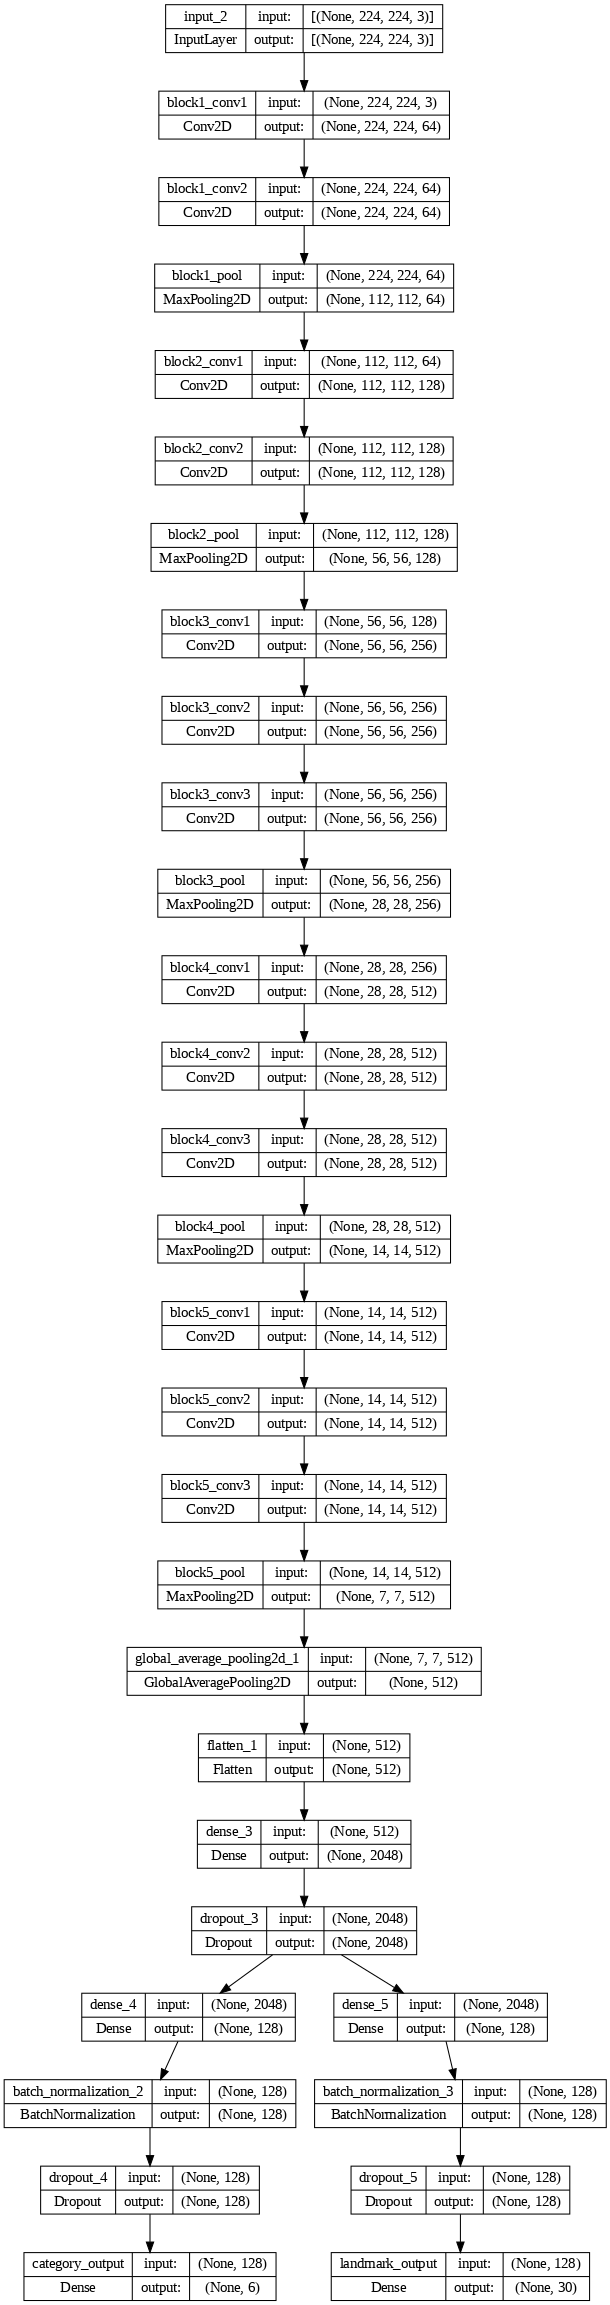

In [ ]:
import tensorflow as tf

# Generating a visual representation of the model architecture
tf.keras.utils.plot_model(model, to_file="category_and_landmark_classifier.png", show_shapes=True, dpi=75)

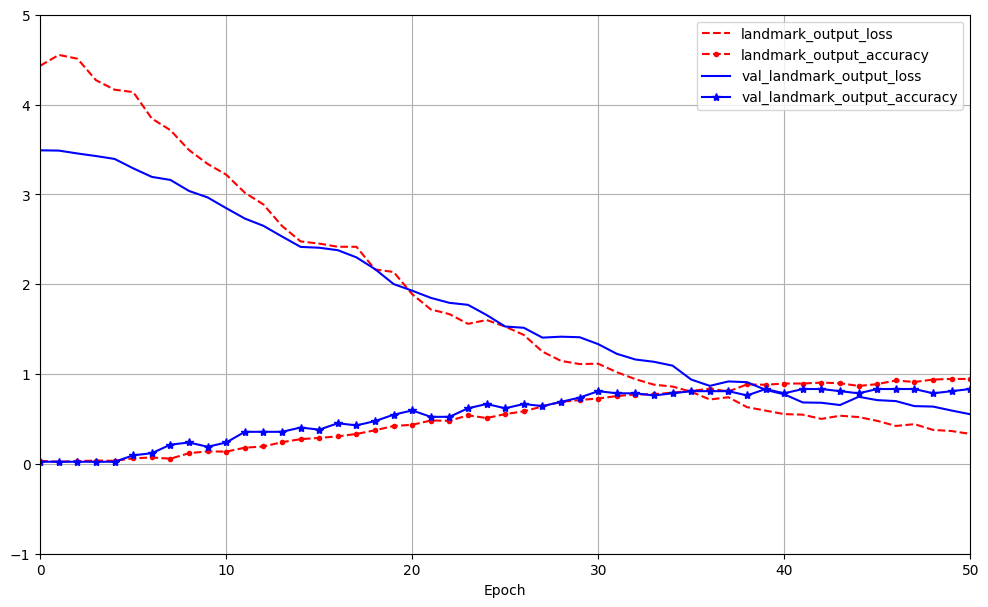

In [ ]:
import matplotlib.pyplot as plt

#Plotting training history for landmark classification loss and accuracy
pd.DataFrame(history.history).iloc[:,[2,4,7,9]].plot(
    figsize=(12, 7), xlim=[0, 50], ylim=[-1, 5], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

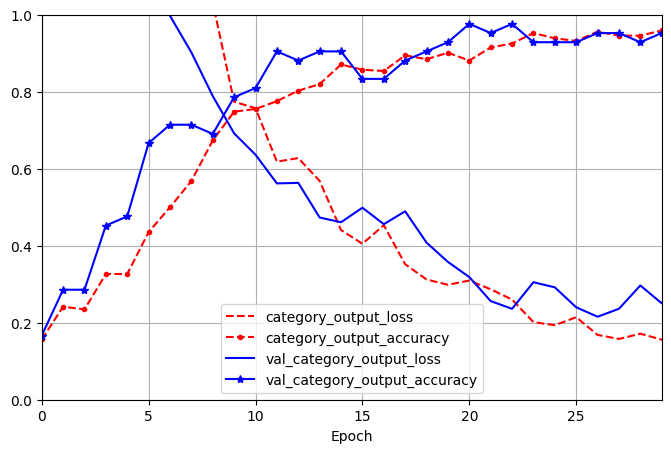

In [ ]:
#Plotting training history for category classification loss and accuracy
pd.DataFrame(history.history).iloc[:,[1,3,6,8]].plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [ ]:
model.save('552.h5')

Category classes:
Landmark classes:


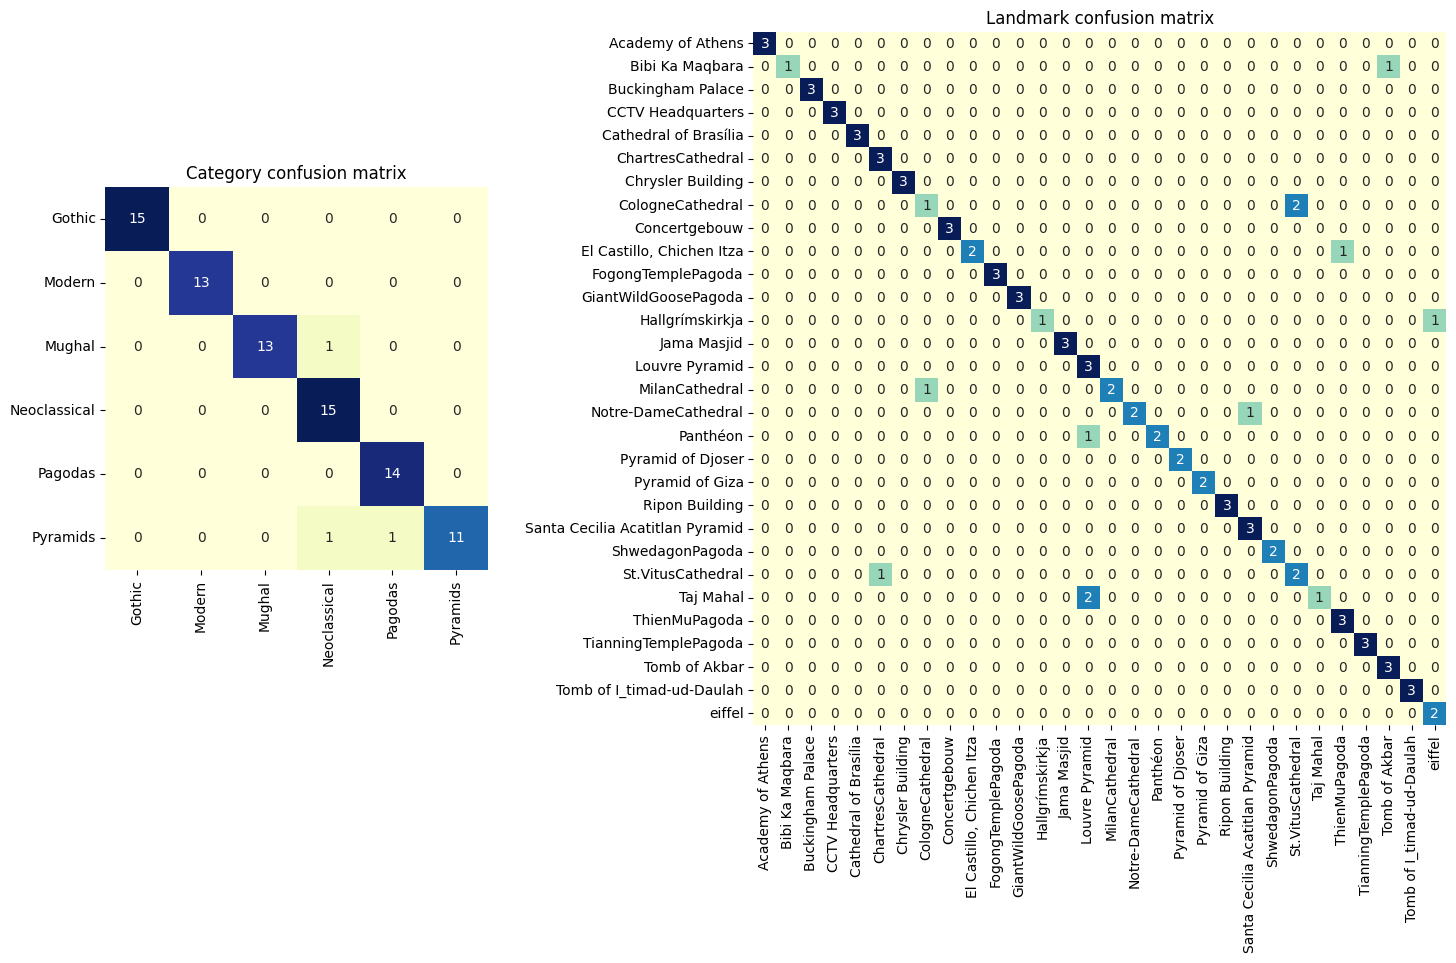

<Figure size 640x480 with 0 Axes>

In [ ]:
# Initializing LabelBinarizer for category labels
lb_category = LabelBinarizer()
category_enc = lb_category.fit(df["category"])
y_category = lb_category.transform(df["category"])

with open("category_encoder.pkl", "wb") as f:
    joblib.dump(category_enc, f)

# Labels
print('Category classes:')
pd.DataFrame(
    zip(
        lb_category.classes_, np.unique(np.argmax(y_category, axis = 1))
    ),
    columns = ["category_name", "label"]
)

# Initialize LabelBinarizer for landmark labels
lb_landmark = LabelBinarizer()
landmark_enc = lb_landmark.fit(df["landmark"])
y_landmark = lb_landmark.transform(df["landmark"])

with open("landmark_encoder.pkl", "wb") as f:
    joblib.dump(landmark_enc, f)

# Labels
print('Landmark classes:')
pd.DataFrame(
    zip(
        lb_landmark.classes_, np.unique(np.argmax(y_landmark, axis = 1))
    ),
    columns = ["landmark_name", "label"]
)

from sklearn.metrics import confusion_matrix

# Compute confusion matrices for category and landmark classification
cat_confusion=confusion_matrix(category_true_labels, category_pred_labels)
land_confusion=confusion_matrix(landmark_true_labels, landmark_pred_labels)
fig = plt.subplots(1,2,figsize=(19,9), gridspec_kw={'width_ratios': [1, 2.5]})

# Plotting category confusion matrix
plt.subplot(121)
cat_l = list(lb_category.classes_)
sns.heatmap(
    cat_confusion, square = True, annot = True, fmt = 'd', cbar = False,
    xticklabels = cat_l, yticklabels = cat_l, cmap = 'YlGnBu'
).set_title('Category confusion matrix')

# Plotting landmark confusion matrix
plt.subplot(122)
land_l = list(lb_landmark.classes_)
sns.heatmap(
    land_confusion, square = True, annot = True, fmt = 'd', cbar = False,
    xticklabels = land_l, yticklabels = land_l, cmap = 'YlGnBu'
).set_title('Landmark confusion matrix')

plt.show()
plt.savefig('my_plot.png')
